# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [8]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1


In [9]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn
import os
import zipfile
import cv2
import shutil
from sklearn.model_selection import train_test_split
# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

Load the dataset.

In [11]:
# Load and unzip the dataset

zip_path = r"D:\MS\Assignment\data.zip"
extract_path = r"D:\MS\Assignment\data"

# check directory exists
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

Dataset extracted to D:\MS\Assignment\data


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [16]:
# Create a function to load the raw images
def load_raw_image(image_path):
    image = cv2.imread(image_path)  
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    return image

In [17]:
image_path = r"D:\MS\Assignment\data\data\Cardboard\file_1.png"
raw_image = load_raw_image(image_path)

if raw_image is not None:
    print(f"Loaded image with shape: {raw_image.shape}")

Loaded image with shape: (256, 256, 3)


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [20]:
# Get the images and their labels

def load_images_and_labels(dataset_dir, target_size=(256, 256)):
    images = []
    labels = []

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue  

        # Iterate through files in every category
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)

            image = cv2.imread(image_path)  
            if image is None:
                print(f"Error loading image: {image_path}")
                continue

            image = cv2.resize(image, target_size)  
            images.append(image)
            labels.append(category)  

    return np.array(images), np.array(labels)

In [21]:
dataset_path = r"D:\MS\Assignment\data\data"  
images, labels = load_images_and_labels(dataset_path)

print(f"Loaded {len(images)} images.")
print(f"Distinct labels: {list(set(labels))}")

Loaded 7625 images.
Distinct labels: ['Cardboard', 'Paper', 'Glass', 'Plastic', 'Food_Waste', 'Other', 'Metal']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

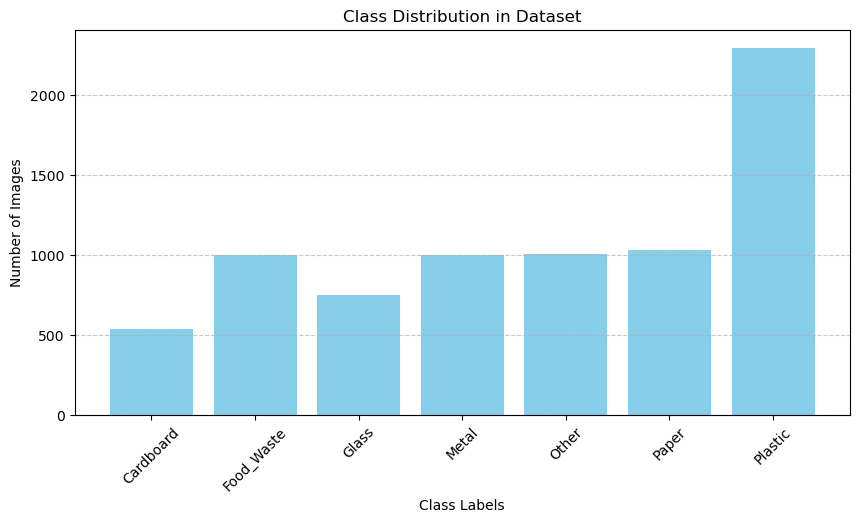

In [25]:
from collections import Counter

# Visualise Data Distribution
label_counts = Counter(labels)

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')

plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [27]:
# Visualise Sample Images (across different labels)
def show_sample_images(images, labels, num_samples=12):
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(20,15))
    for i, idx in enumerate(indices):
        plt.subplot(4, 3,(i%12)+1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(labels[idx])
        plt.axis("off")

    plt.show()


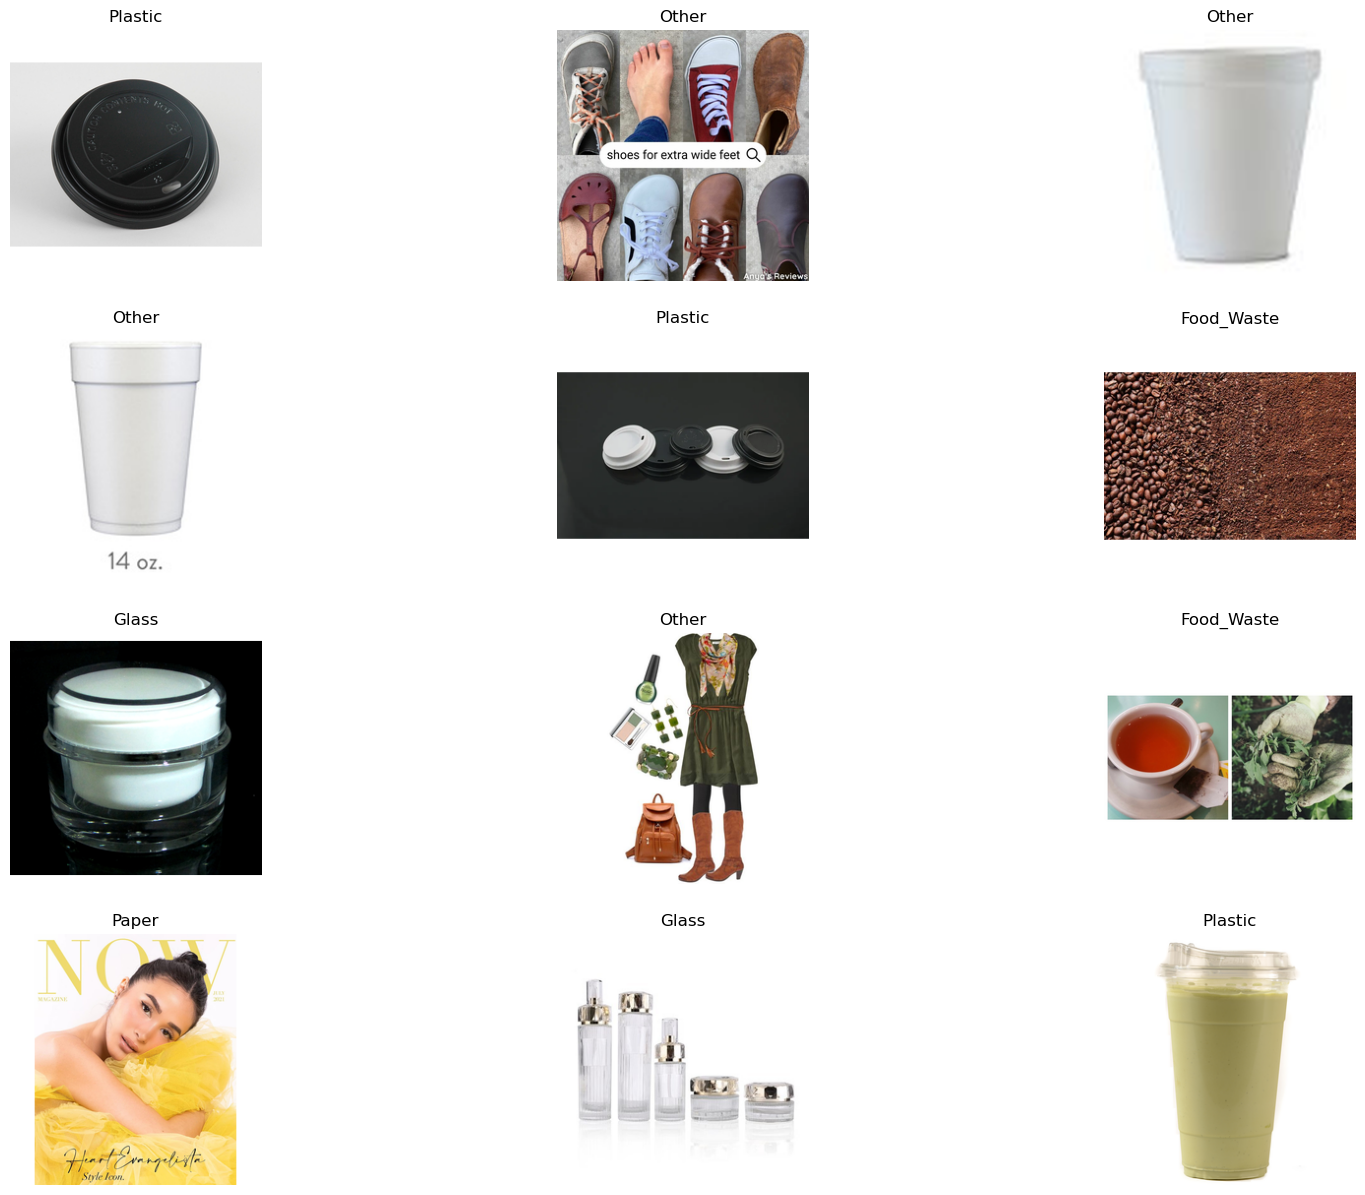

In [28]:
show_sample_images(images, labels)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [30]:
# Find the smallest and largest image dimensions from the data set

def find_image_size_range(dataset_dir):
    min_width, min_height = float("inf"), float("inf")
    max_width, max_height = 0, 0

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue

        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)

            if image is None:
                continue

            h, w, _ = image.shape  
            min_width, min_height = min(min_width, w), min(min_height, h)
            max_width, max_height = max(max_width, w), max(max_height, h)

    return (min_width, min_height), (max_width, max_height)

dataset_path = r"D:\MS\Assignment\data\data"
(min_dim, max_dim) = find_image_size_range(dataset_path)

print(f"Smallest Image Dimensions: {min_dim}")
print(f"Largest Image Dimensions: {max_dim}")

Smallest Image Dimensions: (256, 256)
Largest Image Dimensions: (256, 256)


In [31]:
# Resize the image dimensions, this should overwrite the existing image
def resize_images_pil(dataset_dir, target_size=(128, 128)):
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue

        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            image = Image.open(image_path)

            resized_image = image.resize(target_size, Image.LANCZOS)
            resized_image.save(image_path)  

dataset_path = r"D:\MS\Assignment\data\data"
resize_images_pil(dataset_path)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [35]:
# Encode the labels suitably
from sklearn.preprocessing import LabelEncoder

# use label encoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(f"Label mapping: {label_mapping}")


Label mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [38]:
def split_dataset(dataset_dir, output_dir, test_size=0.2):
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue  

        image_files = os.listdir(category_path)
        
        train_images, test_images = train_test_split(image_files, test_size=test_size, random_state=42, stratify=[category] * len(image_files))

        # Create train and test folders inside
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Move images to respective folders
        for img in train_images:
            shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in test_images:
            shutil.move(os.path.join(category_path, img), os.path.join(test_dir, category, img))

    print(f"Dataset successfully split into 'train' and 'test' folders inside '{output_dir}'.")

In [39]:
dataset_path = r"D:\MS\Assignment\data\data"
output_path = r"D:\MS\Assignment\data\split_data"
split_dataset(dataset_path, output_path)


Dataset successfully split into 'train' and 'test' folders inside 'D:\MS\Assignment\data\split_data'.


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [44]:
# Define dataset paths
train_dir = r"D:\MS\Assignment\data\split_data\train"
test_dir = r"D:\MS\Assignment\data\split_data\test"


In [45]:
# Apply only rescaling (no augmentation)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle =True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle =False
)


Found 6100 images belonging to 7 classes.
Found 1525 images belonging to 7 classes.


In [46]:
# Build and compile the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model
def build_model(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model
model = build_model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,343 (32.37 MB)

 Trainable params: 8,485,895 (32.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [49]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  
]

In [50]:
# Training
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.2795 - loss: 2.5201 - val_accuracy: 0.1902 - val_loss: 3.2796
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.4192 - loss: 1.5556 - val_accuracy: 0.3869 - val_loss: 1.8119
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.4933 - loss: 1.3553 - val_accuracy: 0.5351 - val_loss: 1.3110
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.5451 - loss: 1.2039 - val_accuracy: 0.5548 - val_loss: 1.2112
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.6145 - loss: 1.0369 - val_accuracy: 0.5961 - val_loss: 1.1470
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 190ms/step - accuracy: 0.6657 - loss: 0.8933 - val_accuracy: 0.6170 - val_loss: 1.1214
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.7268 - loss: 0.7302 - val_accuracy: 0.6111 - val_loss: 1.2027
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - accuracy: 0.7659 -

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [84]:
# Save the trained model
model.save("CNN_Assg_Waste_Segregation_Model.h5")

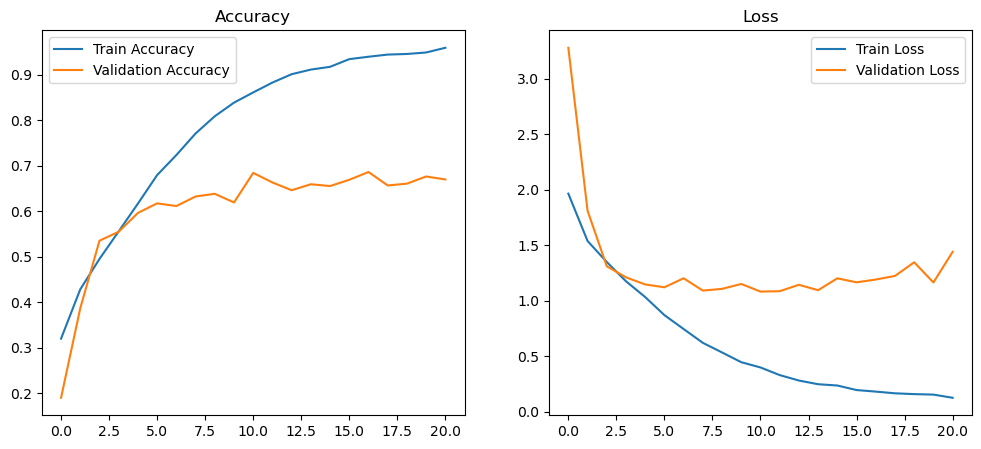

In [88]:
# Evaluate on the test set; display suitable metrics
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [90]:
# Load the Trained Model

from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("CNN_Assg_Waste_Segregation_Model.h5")

# Display the model architecture again to verify loading
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,345 (32.37 MB)

 Trainable params: 8,485,895 (32.37 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [92]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6885 - loss: 1.1372
Test Accuracy: 68.39%
Test Loss: 1.0828


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [151]:
# Define augmentation steps to augment images


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

In [122]:
from collections import Counter

def get_class_distribution(dataset_dir):
    class_counts = {}
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            class_counts[category] = len(os.listdir(category_path))
    return class_counts

dataset_path = r"D:\MS\Assignment\data\split_data\train"
class_distribution = get_class_distribution(dataset_path)
print("Class Distribution:", class_distribution)


Class Distribution: {'Cardboard': 432, 'Food_Waste': 800, 'Glass': 600, 'Metal': 800, 'Other': 808, 'Paper': 824, 'Plastic': 1836}


In [124]:

from imblearn.under_sampling import RandomUnderSampler

def undersample_data(X, y):
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled


Augment the images.

In [156]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(dataset_dir, save_dir, num_augmented=3):
    # Define the augmentation parameters without brightness changes.
    augmented_train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )

    # Loop through each category in your dataset.
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        save_category_path = os.path.join(save_dir, category)

        if not os.path.isdir(category_path):
            continue

        os.makedirs(save_category_path, exist_ok=True)

        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            if image is None:
                continue
            
            # Convert from BGR (OpenCV default) to RGB (expected by Keras)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Add an extra batch dimension required by flow().
            image = np.expand_dims(image, axis=0)
            
            i = 0
            # Generate augmented images.
            for batch in augmented_train_datagen.flow(
                image, batch_size=1, save_to_dir=save_category_path, 
                save_prefix="aug", save_format="jpg"
            ):
                i += 1
                if i >= num_augmented:
                    break

In [158]:
# Create the augmented training dataset
dataset_path = r"D:\MS\Assignment\data\split_data\train"
augmented_dataset_path = r"D:\MS\Assignment\data\split_data\augmented_train_data"

augment_images(dataset_path, augmented_dataset_path)


##### **4.1.2**

Train the model on the new augmented dataset.

In [160]:

augmented_train_dir = r"D:\MS\Assignment\data\split_data\augmented_train_data"
augmented_test_dir = r"D:\MS\Assignment\data\split_data\test"

# Train the model using augmented images
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
augmented_test_datagen = ImageDataGenerator(rescale=1./255)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    augmented_train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle =True
)

augmented_test_generator = augmented_test_datagen.flow_from_directory(
    augmented_test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 15704 images belonging to 7 classes.
Found 1525 images belonging to 7 classes.


In [164]:

# Create the model
augmented_model = build_model()

# Compile the model
augmented_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
augmented_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,343 (32.37 MB)

 Trainable params: 8,485,895 (32.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Build and compile the model

In [ ]:
augmented_history = augmented_model.fit(
    augmented_train_generator,
    validation_data=augmented_test_generator,
    epochs=50,
    verbose=1
)

### As Augmentation was Optional and very time consuming have not completed Augmentation, as with each hyper parameter tuning , running the model was taking good amount of time. 

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

### NOTE : All the results below is without Augmentation

In [94]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6885 - loss: 1.1372
Test Accuracy: 68.39%
Test Loss: 1.0828


In [98]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get actual labels
actual_classes = test_generator.classes

# Compute overall accuracy
overall_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Compute per-class accuracy
cm = confusion_matrix(actual_classes, predicted_classes)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print per-class accuracy
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i} Accuracy: {acc * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Overall Accuracy: 68.39%
Class 0 Accuracy: 75.93%
Class 1 Accuracy: 72.50%
Class 2 Accuracy: 68.67%
Class 3 Accuracy: 64.50%
Class 4 Accuracy: 53.96%
Class 5 Accuracy: 46.60%
Class 6 Accuracy: 82.57%


In [110]:
# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Predicted Classes: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Glass', 'Food_Waste', 'Plastic', 'Cardboard', 'Other']
Actual Classes: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']


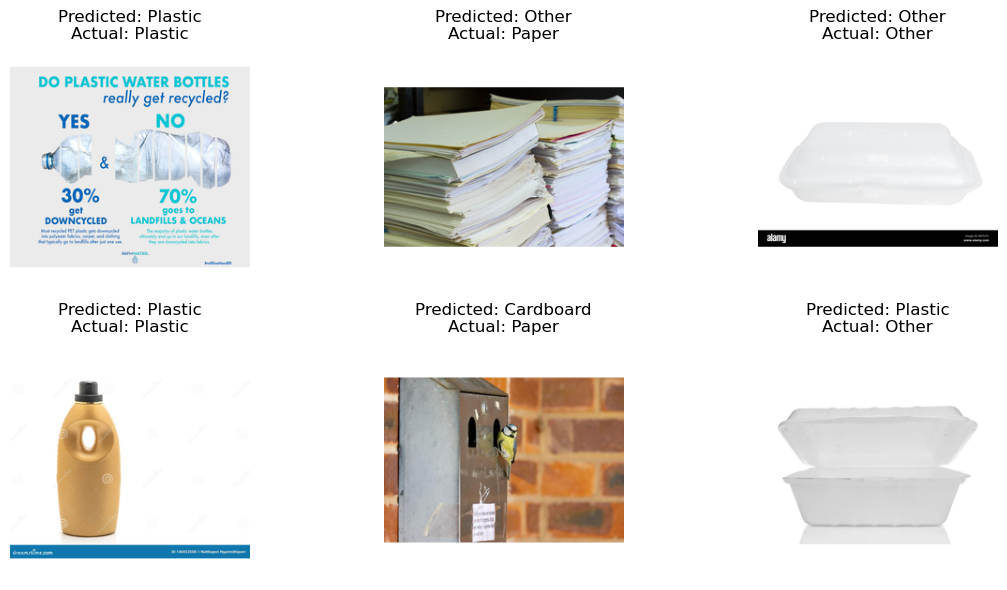

In [112]:
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.85      0.76      0.80       108
  Food_Waste       0.71      0.72      0.72       200
       Glass       0.65      0.69      0.67       150
       Metal       0.75      0.65      0.69       200
       Other       0.65      0.54      0.59       202
       Paper       0.79      0.47      0.59       206
     Plastic       0.63      0.83      0.71       459

    accuracy                           0.68      1525
   macro avg       0.72      0.66      0.68      1525
weighted avg       0.70      0.68      0.68      1525



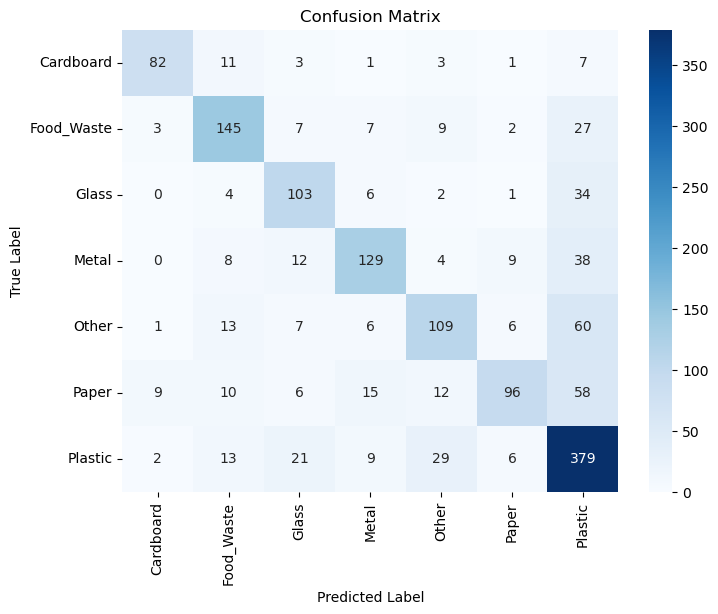

In [114]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#### Without Augmentation
- Paper and Other Section have lowest accuracy
- Plastic, food waste and cardboard have highest accuracy. This clearly shows Augmentation would yeild in better results
- Above mentioned Classification Report and Confusion matrix gives a good overview of how data has been classified with all the required metrics